In [2]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [3]:
ee.Initialize()

In [4]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [5]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

In [19]:
# define basic parameters
year_span = [f'{i}_{i+2}' for i in range(1990,2020,3)]

# fetch the control_sample
Control_sample = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Control_points")

In [64]:
# import the classified imgs
Classified_Landsat_1990_2019  = {f'Landsat_{year}': ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_{year}").sum()
                                for year in year_span}   
                                 

Classified_Sentinel_2014_2019 = {f'Sentinel_{year}':ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Sentinel_Landsat_{year}").sum()   
                                 for year in year_span[-2:]}


# merge two sets of classification together
classified_imgs = Classified_Landsat_1990_2019
classified_imgs.update(Classified_Sentinel_2014_2019)

### Step_1: split control sample and sum up the 10 classifications

In [12]:
# create a function to split control sample

# Note this function is the same to the split process in [Classification] class
# so we will get the same train/test split result if given the same seed.

def sample_split(Verified_point_all,seed):

    # Divede sample into built and non-built
    Verified_point_Built     =  Verified_point_all.filterMetadata('Built','equals',1)
    Verified_point_non_Built =  Verified_point_all.filterMetadata('Built','equals',0)

    # 70/30 Train/Test split on built/non-built points.
    Verified_built_pts_randomcolumn     = Verified_point_Built\
                                          .randomColumn(columnName = 'random',seed = seed) 
    Verified_non_built_pts_randomcolumn = Verified_point_non_Built\
                                          .randomColumn(columnName = 'random',seed = seed)


    Vetified_built_pts_train     = Verified_built_pts_randomcolumn\
                                   .filterMetadata('random',"greater_than",0.3)
    Vetified_built_pts_test      = Verified_built_pts_randomcolumn\
                                   .filterMetadata('random',"not_greater_than",0.3) 

    Vetified_non_built_pts_train = Verified_non_built_pts_randomcolumn\
                                  .filterMetadata('random','greater_than',0.3)
    Vetified_non_built_pts_test  = Verified_non_built_pts_randomcolumn\
                                  .filterMetadata('random','not_greater_than',0.3) 

    # Merge train/test datasets respectively.
    Verified_pts_train = Vetified_built_pts_train.merge(Vetified_non_built_pts_train)
    Verified_pts_test  = Vetified_built_pts_test.merge(Vetified_non_built_pts_test)
    
    return Verified_pts_test

In [31]:
# there set seed to range(10), which is the same to the classification process
# so we can get the same test points.

test_sample = sample_split(Control_sample,i) for i in range(10)

In [69]:
classified_imgs

{'Landsat_1990_1992': <ee.image.Image at 0x2acfc018c88>,
 'Landsat_1993_1995': <ee.image.Image at 0x2acfc018470>,
 'Landsat_1996_1998': <ee.image.Image at 0x2acfc018eb8>,
 'Landsat_1999_2001': <ee.image.Image at 0x2acfc0188d0>,
 'Landsat_2002_2004': <ee.image.Image at 0x2acfc0180f0>,
 'Landsat_2005_2007': <ee.image.Image at 0x2acfc018278>,
 'Landsat_2008_2010': <ee.image.Image at 0x2acfad9a828>,
 'Landsat_2011_2013': <ee.image.Image at 0x2acfadced68>,
 'Landsat_2014_2016': <ee.image.Image at 0x2acfc05b978>,
 'Landsat_2017_2019': <ee.image.Image at 0x2acfae1bb70>,
 'Sentinel_2014_2016': <ee.image.Image at 0x2acfae1b080>,
 'Sentinel_2017_2019': <ee.image.Image at 0x2acfc2885c0>}

In [70]:
# triple-loop to create instances, so we can calculate the accuracy in each img/random/threshold

Acc_threshold = {}

flag = 0
total_ops = len(classified_imgs)*len(test_sample)*10

for name,img in classified_imgs.items():
    for i,sample in enumerate(test_sample):
        for threshold in range(1,11):
            
            # update the flag
            flag = flag + 1
            
            # apply the threshold to the sum of 10 classifications,rename so we can use Accuracyassement module
            img_threshold = img.gte(threshold).rename('classification')
            
            # extract reclassified GAIA pixel value to test_sample
            sample_with_value = img_threshold.sampleRegions(collection = sample, 
                                                            properties = ['Built'], 
                                                            scale      = 30)
            
            # compute the accuracy 
            Acc_threshold[(name,threshold,i)] = Accuracy_assesment(sample_with_value).Stp_1_Calculate_Accuracy()
            
            # print out the process
            print(f'Accuracy computation of {name}-{threshold}-{i} complete!  ==> {flag}/{total_ops}')
            
            

Accuracy computation of Landsat_1990_1992-1-0 complete!  ==> 1/1200
Accuracy computation of Landsat_1990_1992-2-0 complete!  ==> 2/1200
Accuracy computation of Landsat_1990_1992-3-0 complete!  ==> 3/1200
Accuracy computation of Landsat_1990_1992-4-0 complete!  ==> 4/1200
Accuracy computation of Landsat_1990_1992-5-0 complete!  ==> 5/1200
Accuracy computation of Landsat_1990_1992-6-0 complete!  ==> 6/1200
Accuracy computation of Landsat_1990_1992-7-0 complete!  ==> 7/1200
Accuracy computation of Landsat_1990_1992-8-0 complete!  ==> 8/1200
Accuracy computation of Landsat_1990_1992-9-0 complete!  ==> 9/1200


..\BackGround_modules\Class_3_Calculate_the_accuracy.py:82: RuntimeWarning: invalid value encountered in true_divide
  precision_acc = np.diag(self.error_matrix)/np.sum(self.error_matrix,axis=0)


Accuracy computation of Landsat_1990_1992-10-0 complete!  ==> 10/1200
Accuracy computation of Landsat_1990_1992-1-1 complete!  ==> 11/1200
Accuracy computation of Landsat_1990_1992-2-1 complete!  ==> 12/1200
Accuracy computation of Landsat_1990_1992-3-1 complete!  ==> 13/1200
Accuracy computation of Landsat_1990_1992-4-1 complete!  ==> 14/1200
Accuracy computation of Landsat_1990_1992-5-1 complete!  ==> 15/1200
Accuracy computation of Landsat_1990_1992-6-1 complete!  ==> 16/1200
Accuracy computation of Landsat_1990_1992-7-1 complete!  ==> 17/1200
Accuracy computation of Landsat_1990_1992-8-1 complete!  ==> 18/1200
Accuracy computation of Landsat_1990_1992-9-1 complete!  ==> 19/1200
Accuracy computation of Landsat_1990_1992-10-1 complete!  ==> 20/1200
Accuracy computation of Landsat_1990_1992-1-2 complete!  ==> 21/1200
Accuracy computation of Landsat_1990_1992-2-2 complete!  ==> 22/1200
Accuracy computation of Landsat_1990_1992-3-2 complete!  ==> 23/1200
Accuracy computation of Landsat_

Accuracy computation of Landsat_1993_1995-9-2 complete!  ==> 129/1200
Accuracy computation of Landsat_1993_1995-10-2 complete!  ==> 130/1200
Accuracy computation of Landsat_1993_1995-1-3 complete!  ==> 131/1200
Accuracy computation of Landsat_1993_1995-2-3 complete!  ==> 132/1200
Accuracy computation of Landsat_1993_1995-3-3 complete!  ==> 133/1200
Accuracy computation of Landsat_1993_1995-4-3 complete!  ==> 134/1200
Accuracy computation of Landsat_1993_1995-5-3 complete!  ==> 135/1200
Accuracy computation of Landsat_1993_1995-6-3 complete!  ==> 136/1200
Accuracy computation of Landsat_1993_1995-7-3 complete!  ==> 137/1200
Accuracy computation of Landsat_1993_1995-8-3 complete!  ==> 138/1200
Accuracy computation of Landsat_1993_1995-9-3 complete!  ==> 139/1200
Accuracy computation of Landsat_1993_1995-10-3 complete!  ==> 140/1200
Accuracy computation of Landsat_1993_1995-1-4 complete!  ==> 141/1200
Accuracy computation of Landsat_1993_1995-2-4 complete!  ==> 142/1200
Accuracy computati

KeyboardInterrupt: 

In [74]:
df = pd.DataFrame(Acc_threshold).T

In [76]:
df = df.reset_index()

In [78]:
test = df[df['level_0'] == 'Landsat_1990_1992']

In [79]:
test

,level_0,level_1,level_2,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
0,Landsat_1990_1992,1,0,2.34,4.39,0.00,4.76,0.00
1,Landsat_1990_1992,2,0,1.64,3.12,0.00,3.34,0.00
2,Landsat_1990_1992,3,0,1.03,1.82,0.17,1.92,0.16
3,Landsat_1990_1992,4,0,0.70,0.96,0.42,1.00,0.40
4,Landsat_1990_1992,5,0,0.82,0.57,1.08,0.58,1.05
...,...,...,...,...,...,...,...,...
95,Landsat_1990_1992,6,9,0.68,0.09,1.25,0.08,1.30
96,Landsat_1990_1992,7,9,1.16,0.00,2.23,0.00,2.34
97,Landsat_1990_1992,8,9,1.97,0.00,3.75,0.00,3.98
98,Landsat_1990_1992,9,9,2.95,0.00,5.52,0.00,5.97


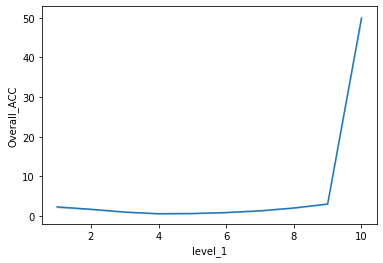

In [80]:
sns.lineplot(data = test,x='level_1',y='Overall_ACC')

In [83]:
sample_with_value.size().getInfo()

2439